# Construction jobs analysis

By [Ben Welsh](mailto:ben.welsh@latimes.com)

The Los Angeles Times conducted an analysis of federal data to evaluate the makeup and pay of construction work. 

The analysis found that wages have been in decline nationwide for several decades. In LA County, this has coincided with a shift to a workforce made up overwhelmingly of Latinos, which leads a nationwide trend in the industry toward employing more Latino workers.

Those results were published in the April 20, 2017 story ["Immigrants flooded California construction. Worker pay sank. Here’s why"](http://www.latimes.com/projects/la-fi-construction-trump/).

The story cities other studies by UCLA, unionstats.com and other sources that are not reproduced here.

## How we did it

Downloaded data on wages from the Bureau of Labor Statistics'  [Current Employment Statistics Program](https://www.bls.gov/ces/) and prepared it for analysis.

In [1]:
%%capture
%run bls/01-download.ipynb
%run bls/02-transform.ipynb

Downloaded U.S. Census data tracking the hispanic ethnicity of adult workers in Los Angeles by industry from the University of Minnesota's [IPUMS online data analysis system](https://usa.ipums.org/usa/sda/) and prepared it for analysis.

In [96]:
%run ipums/01-transform.ipynb

### Finding 1: Construction workers more than 5 dollars an hour less today than they in 1972, when pay in the field peaked

In [1]:
import cpi
import calculate
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

Read in BLS data that tracks a number of metrics by industry 

In [4]:
bls = pd.read_csv("./bls/output/bls_ce_transformed.csv")

Filter down to unadjusted data, as recommended by BLS staff

In [5]:
bls = bls[bls.seasonal == 'U']

Filter down to records that track large sectors of the economy the BLS calls "super sectors." Construction is one of them.

In [6]:
bls = bls[bls.supersector_name == bls.industry_name]

Filter down to data tracking the average hourly pay for non-supervisors in each supersector

In [7]:
bls = bls[
    bls.data_type_text == 'AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES'
]

Filter down to annual totals

In [8]:
bls = bls[bls.period == 'M13']

Adjust the wages for inflation to 2016 dollars using the Consumer Price Index

In [9]:
bls['value_2016_dollars'] = bls.apply(
    lambda x: cpi.to_2016_dollars(x.value, x.year),
    axis=1
)

Trim that data down and chart the change in Construction pay

In [10]:
bls_construction = bls[
    bls.supersector_name == 'Construction'
].set_index("year")

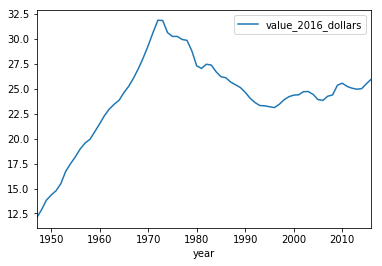

In [11]:
bls_construction[['value_2016_dollars']].plot()

In [42]:
bls_construction[['value_2016_dollars']][bls_construction.index > 1972].to_csv("./bls/output/graphic.csv")

What as the peak year?

In [12]:
bls_construction.sort_values(
    "value_2016_dollars",
    ascending=False
).value_2016_dollars.head(1)

year
1972    31.866958
Name: value_2016_dollars, dtype: float64

How much do they make today?

In [13]:
bls_construction.sort_index(
    ascending=False
).value_2016_dollars.head(1)

year
2016    25.97
Name: value_2016_dollars, dtype: float64

How much has pay declined between the two years?

In [14]:
max_construction_pay = bls_construction.at[1972, 'value_2016_dollars']

In [15]:
construction_pay_today = bls_construction.at[2016, 'value_2016_dollars']

In [16]:
construction_pay_today - max_construction_pay

-5.8969581339712924

### Finding 2: At its peak, construction paid almost $10 more than the average hourly job in the private sector. But as real pay steadily declined for decades, much of that gap was erased.

Pull the same time series for the private sector as a whole

In [17]:
bls_overall = bls[
    bls.supersector_name == 'Total private'
].set_index("year")

Compare the two

In [18]:
bls_comparison = pd.merge(
    bls_construction.reset_index()[['year', 'value_2016_dollars']],
    bls_overall.reset_index()[['year', 'value_2016_dollars']],
    on="year",
    suffixes=["_construction", "_private"]
).set_index("year")

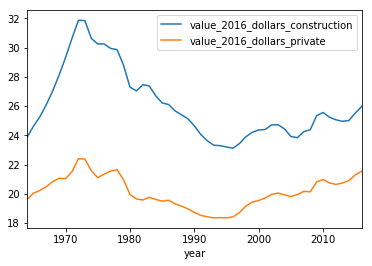

In [19]:
bls_comparison.plot()

Measure the difference

In [23]:
bls_comparison['diff'] = bls_comparison.apply(
    lambda x: x.value_2016_dollars_construction - x.value_2016_dollars_private,
    axis=1
)

What year was the gap the greatest?

In [24]:
bls_comparison.sort_values("diff", ascending=False).head(1)

,value_2016_dollars_construction,value_2016_dollars_private,diff
year,,,
1972,31.866958,22.392998,9.473961


What is the gap today?

In [25]:
bls_comparison.sort_index(ascending=False).head(1)

,value_2016_dollars_construction,value_2016_dollars_private,diff
year,,,
2016,25.97,21.54,4.43


### Finding 3: Even as homebuilding exploded from 2011 to 2016, hourly wages for construction laborers rose slower than average pay.

Extract out the pay for those two years

In [26]:
bls_11v16 = bls_comparison[
    (bls_comparison.index == 2011) |
    (bls_comparison.index == 2016)
]

Calculate the percentage increase for construction

In [27]:
calculate.percentage_change(*bls_11v16.value_2016_dollars_construction)

2.9157056562594472

Do the same for the overall private sector

In [28]:
calculate.percentage_change(*bls_11v16.value_2016_dollars_private)

3.8461236753022447

### Finding 4: Seventy percent of construction workers in Los Angeles are Latino.

Read in construction industry worker totals by hispanic status, retrieved from the University of Minnesota's IPUMS compilation of U.S. Census data.

In [29]:
la_hispanics = pd.read_csv("./ipums/output/hispanics_la_combined.csv")

Plot it by year

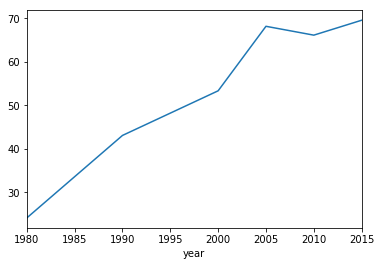

In [30]:
la_hispanics[['year', 'latino_percent']].reset_index().set_index("year").latino_percent.plot()

Output the totals

In [31]:
la_hispanics[['year', 'latino_percent']]

,year,latino_percent
0,1980,24.155741
1,1990,43.102641
2,2000,53.354025
3,2005,68.171001
4,2010,66.138752
5,2015,69.562059


In [43]:
la_hispanics[['year', 'latino_percent']].to_csv("./ipums/output/graphic.csv", index=False)